In [110]:
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [111]:
import seaborn as sns

In [112]:
import torch, torchvision
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import shap

In [113]:
data = pd.read_csv('./statistic_2022_12_03.csv').drop(['Unnamed: 0'], axis=1)

In [114]:
data = data[data['scan_result'] != 'PLT1234567890']

In [115]:
import ipyplot

train_image_paths = list(data['plt_dir'])
train_labels = list(data['is_touched'].astype(np.uint8))
ipyplot.plot_class_tabs(train_image_paths, train_labels, max_imgs_per_tab=1000)

# Обучим бейзлайн модель

In [116]:
data = data.dropna()

In [117]:
data['is_touched'] = data['is_touched'].astype(int)

In [118]:
import seaborn as sns

<AxesSubplot: xlabel='is_touched', ylabel='Count'>

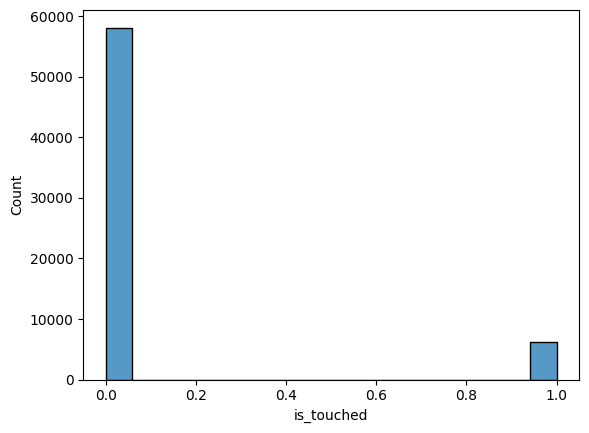

In [119]:
sns.histplot(data['is_touched'])

In [120]:
import torch
torch.cuda.is_available()

True

In [121]:
import pandas as pd
import ipyplot
import torch
import pytorch_lightning as pl
from sklearn.metrics import f1_score, accuracy_score

In [122]:
all_images = list(data['plt_dir'])

In [123]:
# import cv2

# all_shapes = []
# for img_name in all_images:
#     img = cv2.imread(img_name)
#     all_shapes.append(img.shape[:2])

In [124]:
# Размеры разные
# np.unique(all_shapes)

In [125]:
from torchvision import transforms
import functools
import matplotlib.pyplot as plt

transform_train = transforms.Compose(
    [   
        transforms.ToTensor(),
        transforms.Resize((608, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.25, 0.1, 0.1, 0.0),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)


transform = transforms.Compose(
    [   
        transforms.ToTensor(),
        transforms.Resize((608, 256)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

inv_im_trans = transforms.Normalize(
                mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                std=[1/0.229, 1/0.224, 1/0.225])

In [126]:
from torch.utils.data import Dataset
from skimage import io
#from pyzbar.pyzbar import decode

class ImagesDataset(Dataset):
    def __init__(self, image_paths, labels = None, transform=None):
        super().__init__()
        self.image_paths = image_paths
        self.labels = labels
        self.targets = self.labels
        self.transform = transform
        
        if self.labels is not None:
            assert len(self.image_paths) == len(self.labels)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if self.labels is not None:
            label = self.labels[idx]
        else:
            label = -1
        img = io.imread(self.image_paths[idx])
        img = img[...,:3]
        
        if self.transform:
            img = self.transform(img)

        return img, label
    
    

class PalletesDataset(Dataset):
    def __init__(self, pallets, data, transform=None):
        super().__init__()
        self.data = data
        self.pallets = pallets
        self.transform = transform

    def __len__(self):
        return len(self.pallets)

    def __getitem__(self, idx):
        
        plts = self.pallets[idx]
        subs = self.data[self.data['scan_result'] == plts]
        sample = subs.sample(1)
        img = io.imread(list(sample['plt_dir'])[0])
        img = img[...,:3]
        label = int(sample['is_touched'])
        if self.transform:
            img = self.transform(img)

        return img, label

In [127]:
data = data.sort_values(by=['scan_result'])

In [21]:
import tqdm

deltas = []
cnt_reversed = 0
bad_palletes = []
for plts in tqdm.tqdm(sorted(set(data['scan_result']))):
    subs = data[data['scan_result'] == plts].sort_values(by=['add_date']).reset_index()
    touch_date = None
    for idx, row in subs.iterrows():
        if row['is_touched'] and touch_date is None:
            touch_date = row['add_date']
        if not row['is_touched'] and touch_date and row['add_date'] > touch_date:
            #print(touch_date, row['add_date'])
            #print(row['scan_result'])
            bad_palletes.append(row['scan_result'])
            cnt_reversed += 1
            break

100%|█████████████████████████████████████████████████████████████████████████████| 5583/5583 [00:27<00:00, 200.86it/s]


In [153]:
data['is_noisy_label'] = 0

In [155]:
import tqdm

deltas = []
cnt_reversed = 0
bad_palletes = []
for plts in sorted(set(data['scan_result'])):
    subs = data[data['scan_result'] == plts]
    if sum(subs['is_touched']):
        touched_loc = set(subs[subs['is_touched'] == 1]['location'])
        data.loc[(data['scan_result'] == plts) & (data['is_touched'] == 0) & (~data['location'].isin(touched_loc)), 'is_noisy_label'] = 1
        data.loc[(data['scan_result'] == plts) & (data['is_touched'] == 0) & (data['location'].isin(touched_loc)), 'is_noisy_label'] = 2

In [156]:
train_dataset = PalletesDataset(data['scan_result'], data, transform=transform_train)

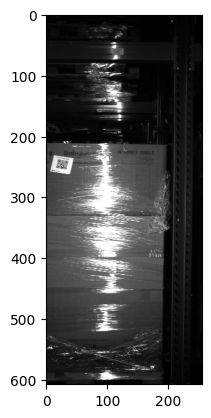

In [157]:
plt.imshow(inv_im_trans(train_dataset[0][0]).permute(1, 2, 0).numpy())

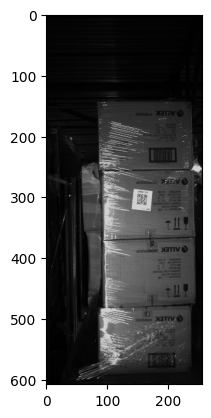

In [158]:
plt.imshow(inv_im_trans(train_dataset[10][0]).permute(1, 2, 0).numpy())

In [159]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# train_indices, val_indices, _, _ = train_test_split(range(len(train_dataset)), train_dataset.targets, 
#                                                     stratify=train_dataset.targets, test_size=0.3, random_state=1337)
# train_split = Subset(train_dataset, train_indices)
# val_split = Subset(train_dataset, val_indices)

In [134]:
#data = data[data['is_noisy_label'] != 1]
pallets = sorted(set(data['scan_result'])) # - set(bad_palletes))
train_pallets, test_pallets = train_test_split(pallets, test_size=0.3, random_state=1337)
data_train, data_test = data.loc[data['scan_result'].isin(train_pallets)], data.loc[data['scan_result'].isin(test_pallets)]
data_train = data_train
data_test = data_test

In [135]:
np.mean(data_train['is_touched'])

0.0952832477011621

In [136]:
np.mean(data_test['is_touched'])

0.1021093504040298

In [137]:
len(data_train)

45349

In [138]:
len(data_test)

19058

In [139]:
train_split = PalletesDataset(train_pallets, data_train, transform=transform_train)
val_split = ImagesDataset(list(data_test['plt_dir']), list(data_test['is_touched']), transform=transform)

In [140]:
len(train_split)

3908

In [141]:
train_loader = torch.utils.data.DataLoader(train_split, 
                                           batch_size=16,
                                           num_workers=0,
                                           shuffle=True,
                                           drop_last=True)

val_loader = torch.utils.data.DataLoader(val_split, 
                                         batch_size=32,
                                         num_workers=0,
                                         shuffle=False)

In [109]:
import torch
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch import nn
from torch.nn import *
import pytorch_lightning as pl
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
import timm
import torchmetrics

class ImageClassifier(pl.LightningModule):
    def __init__(self, trunk=None, class_weight=None, learning_rate=1e-4):
        super().__init__()
        self.class_weight = class_weight
        self.trunk = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.trunk.fc = nn.Sequential(
                            #nn.Dropout(0.5),
                            nn.Linear(2048, 2)
                        )
        self.learning_rate = learning_rate
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.train_f1 = torchmetrics.F1Score(task="binary")
        self.train_auc = torchmetrics.AUROC(task="binary")
        self.train_pr = torchmetrics.AveragePrecision(task="binary")
        
        self.val_accuracy = torchmetrics.Accuracy(task="binary")
        self.val_f1 = torchmetrics.F1Score(task="binary")
        self.val_auc = torchmetrics.AUROC(task="binary")
        self.val_pr = torchmetrics.AveragePrecision(task="binary")
        
    def forward(self, x):
        return self.trunk(x)

    def predict_proba(self, x):
        probabilities = nn.functional.softmax(self.forward(x), dim=1)
        return probabilities

    def predict(self, x):
        return torch.max(self.forward(x), 1)[1]

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),
                                      lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss(weight=self.class_weight)(y_hat, y)
        self.log("train_loss", loss)
        
        y_hat = nn.functional.softmax(y_hat, dim=1)[:, 1]
        self.train_accuracy.update(y_hat, y)
        self.log('train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        self.train_f1.update(y_hat, y)
        self.log('train_f1', self.train_f1, on_step=False, on_epoch=True)
        self.train_auc.update(y_hat, y)
        self.log('train_auc', self.train_auc, on_step=False, on_epoch=True)
        self.train_pr.update(y_hat, y)
        self.log('train_pr', self.train_pr, on_step=False, on_epoch=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss(weight=self.class_weight)(y_hat, y)
        self.log("val_loss", loss)
        
        y_hat = nn.functional.softmax(y_hat, dim=1)[:, 1]
        self.val_accuracy.update(y_hat, y)
        self.log('val_acc', self.val_accuracy, on_step=False, on_epoch=True)
        self.val_f1.update(y_hat, y)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True)
        self.val_auc.update(y_hat, y)
        self.log('val_auc', self.val_auc, on_step=False, on_epoch=True)
        self.val_pr.update(y_hat, y)
        self.log('val_pr', self.val_pr, on_step=False, on_epoch=True)

In [108]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers as pl_loggers

#tb_logger = pl_loggers.TensorBoardLogger(save_dir="C:/Users/andry/Desktop/MarketPrj/lightning_logs/", version='remove_noise_lsmooth')
model = ImageClassifier(learning_rate=1e-4)
checkpoint_callback = ModelCheckpoint(dirpath="./saves", save_top_k=2, monitor="val_pr", mode="max")
trainer = pl.Trainer(
    #logger=tb_logger,
    callbacks=[checkpoint_callback],
    max_epochs=1000,
    log_every_n_steps=-1,
    accelerator='gpu'
)
trainer.fit(model, train_loader, val_loader)
trainer.save_checkpoint("model_resnet50_aug_new_data.ckpt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Checkpoint directory C:\Users\andry\Desktop\MarketPrj\saves exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                   | Params
----------------------------------------------------------
0 | trunk          | ResNet                 | 23.5 M
1 | train_accuracy | BinaryAccuracy         | 0     
2 | train_f1       | BinaryF1Score          | 0     
3 | train_auc      | BinaryAUROC            | 0     
4 | train_pr       | BinaryAveragePrecision | 0     
5 | val_accuracy   | BinaryAccuracy         | 0     
6 | val_f1         | BinaryF1Score          | 0     
7 | val_auc        | BinaryAUROC            | 0     
8 | val_pr         | BinaryAveragePrecision | 0     
----------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Tota

Sanity Checking: 0it [00:00, ?it/s]

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Detected KeyboardInterrupt, attempting graceful shutdown...


KeyboardInterrupt: 

In [142]:
import torch
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch import nn
from torch.nn import *
import pytorch_lightning as pl
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
import timm
import torchmetrics

class ImageClassifier(nn.Module):
    def __init__(self, trunk=None, class_weight=None, learning_rate=1e-4):
        super().__init__()
        self.class_weight = class_weight
        self.trunk = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        self.trunk.fc = nn.Sequential(
                            #nn.Dropout(0.5),
                            nn.Linear(2048, 2)
                        )

    def forward(self, x):
        return self.trunk(x)

    def predict_proba(self, x):
        probabilities = nn.functional.softmax(self.forward(x), dim=1)
        return probabilities

    def predict(self, x):
        return torch.max(self.forward(x), 1)[1]

In [143]:
model = ImageClassifier(learning_rate=1e-4).cuda()

In [144]:
model.load_state_dict(torch.load('./saves/epoch=5-step=1464.ckpt')['state_dict'])
model.eval()

ImageClassifier(
  (trunk): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [145]:
import tqdm.auto as tqdm

def evaluate_model_val(model, loader):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for x, y in tqdm.tqdm(loader):
            prediction = model.predict_proba(x.to('cuda')).cpu().numpy()
            predictions += list(prediction)
            labels += list(y.numpy())
    return labels, predictions

In [160]:
#data = data[data['is_noisy_label'] != 1]
pallets = sorted(set(data['scan_result'])) # - set(bad_palletes))
train_pallets, test_pallets = train_test_split(pallets, test_size=0.3, random_state=1337)
data_train, data_test = data.loc[data['scan_result'].isin(train_pallets)], data.loc[data['scan_result'].isin(test_pallets)]
data_train = data_train
data_test = data_test

In [163]:
data_test = data_test[data_test['is_noisy_label'] != 1]

In [164]:
val_split = ImagesDataset(list(data_test['plt_dir']), list(data_test['is_touched']), transform=transform)

In [165]:
val_loader = torch.utils.data.DataLoader(val_split, batch_size=16, num_workers=0, shuffle=False)
labels, predictions = evaluate_model_val(model, val_loader)


  6%|████▍                                                                           | 65/1173 [00:16<04:34,  4.04it/s]


 11%|████████▊                                                                      | 131/1173 [00:32<04:20,  3.99it/s]


 17%|█████████████▎                                                                 | 197/1173 [00:48<03:55,  4.14it/s]


 22%|█████████████████▋                                                             | 263/1173 [01:04<03:44,  4.05it/s]


 28%|██████████████████████▏                                                        | 329/1173 [01:20<03:22,  4.16it/s]


 34%|██████████████████████████▌                                                    | 395/1173 [01:36<03:04,  4.21it/s]


 39%|███████████████████████████████                                                | 461/1173 [01:52<02:51,  4.14it/s]


 45%|███████████████████████████████████▍                                           | 527/1173 [02:08<02:39,  4.05it/s]


 51%|███████████████████████████████████████▉                                       | 593/1173 [02:24<02:23,  4.05it/s]


 56%|████████████████████████████████████████████▍                                  | 659/1173 [02:40<02:05,  4.08it/s]


 62%|████████████████████████████████████████████████▊                              | 725/1173 [02:56<01:53,  3.96it/s]


 67%|█████████████████████████████████████████████████████▎                         | 791/1173 [03:12<01:36,  3.95it/s]


 73%|█████████████████████████████████████████████████████████▋                     | 857/1173 [03:28<01:19,  4.00it/s]


 79%|██████████████████████████████████████████████████████████████▏                | 923/1173 [03:44<01:01,  4.06it/s]


 84%|██████████████████████████████████████████████████████████████████▌            | 989/1173 [04:01<00:47,  3.86it/s]


 90%|██████████████████████████████████████████████████████████████████████▏       | 1055/1173 [04:18<00:30,  3.90it/s]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1121/1173 [04:35<00:13,  3.94it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 1173/1173 [04:49<00:00,  4.06it/s]


In [166]:
conf = np.array(predictions)[:, 1]

In [167]:
preds = conf.copy()

In [168]:
labels = np.array(labels)

auc=0.396


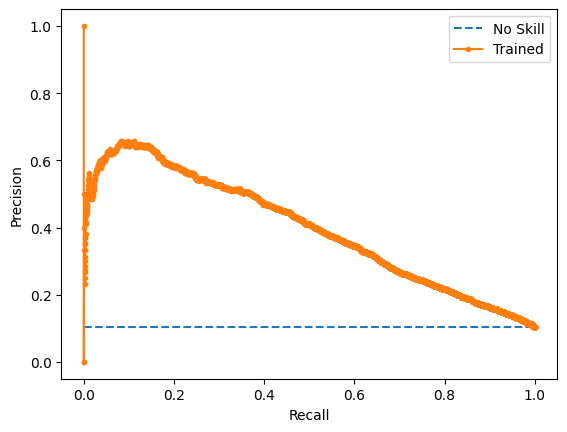

In [169]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

lr_precision, lr_recall, _ = precision_recall_curve(labels, conf)
lr_auc = auc(lr_recall, lr_precision)
# summarize scores
print('auc=%.3f' % (lr_auc))
# plot the precision-recall curves
no_skill = len(labels[labels==1]) / len(labels)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Trained')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.816


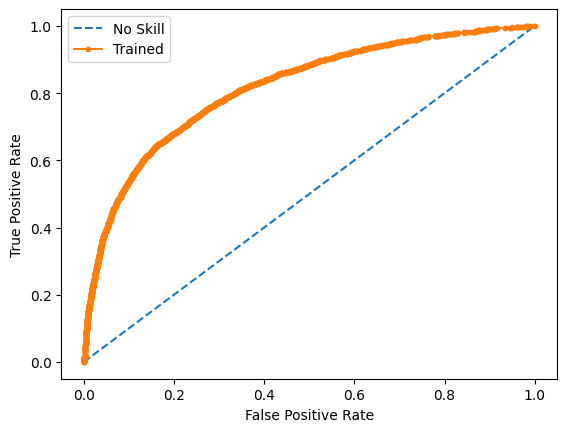

In [170]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# calculate scores
ns_probs = [0 for _ in range(len(labels))]
ns_auc = roc_auc_score(labels, ns_probs)
lr_auc = roc_auc_score(labels, conf)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(labels, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(labels, conf)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Trained')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

auc=0.381


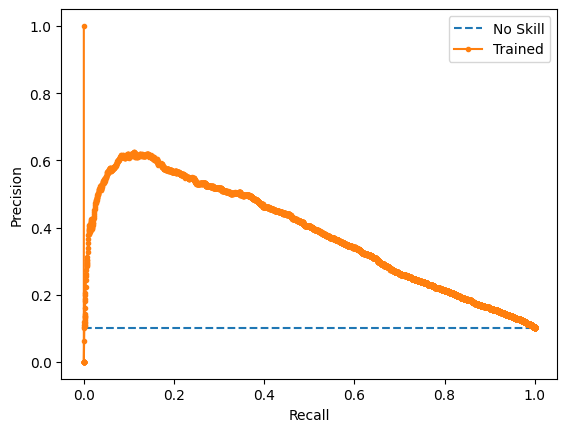

In [150]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

lr_precision, lr_recall, _ = precision_recall_curve(labels, conf)
lr_auc = auc(lr_recall, lr_precision)
# summarize scores
print('auc=%.3f' % (lr_auc))
# plot the precision-recall curves
no_skill = len(labels[labels==1]) / len(labels)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Trained')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()